#<center>COMP561 Assignment 3</center>

##Part 1: Finding consensus sequence
Write a program to determine what is the 6-nucleotide consensus sequence (made of the extended alphabet A, C, G, T, A|C, A|G, A|T, C|G, C|T, G|T, A|C|G|T ) that is the most likely to represent the transcription factor binding site of GATA2. It is up to you to decide how to approach this problem. Don’t go overboard here – a relatively simple approach should be able to get you to the answer. No need to implement any of the fancy algorithms that researchers have published in research papers – stick to the ideas and math we’ve seen in class.

In [168]:
import itertools

with open("GATA2_chr1.fa","r") as f1:
    GATA2 = [(line.rstrip('\n')) for line in f1]
with open("not_GATA2_chr1.fa","r") as f2:
    NotGATA2 = [(line.rstrip('\n')) for line in f2]

In [169]:
def separate(MyFile):
    
    var = 0
    str1 = None
    temp1 = []
    temp2 = []
    length = len(MyFile)
    
    while var < length:
        plusOne = var + 1
        if MyFile[var][0] is (">"):
            temp1.append(MyFile[var])
        else:
            if str1 is None:
                str1 = MyFile[var]
            else:
                str1 = str1 + MyFile[var]
            
            if plusOne < length:
                if MyFile[plusOne][0] is (">"):
                    temp2.append(str1)
                    str1 = None
            if plusOne == length:
                temp2.append(str1)
                str1 = None
                return temp2
        var += 1
        
    return temp2

In [184]:
def createConsensus():
    possible = ["A","C","G","T"]

    expectLength = 6
    possibleConsensus = []
    for p in itertools.product(possible,repeat=6):
        sequence = (''.join(p))
        possibleConsensus.append(sequence)
    
    return possibleConsensus

def update(myfile,possibleConsensus):
    
    countList = [0] * len(possibleConsensus)
    
    for a in range(len(myfile)):
        wholeSequence = myfile[a]
        seqList=[]
        
        for i in range(len(wholeSequence)-6):
            sequence = wholeSequence[i:i+6]
            if sequence not in seqList:
                seqList.append(sequence)
                countList[possibleConsensus.index(sequence)] += 1
   
    return countList

def getScore(NwGATA,NwNOT):
    score = NwGATA - NwNOT
    return score

In [172]:
gata2 = separate(GATA2)
notgata2 = separate(NotGATA2)

possibleConsensus = createConsensus()


In [173]:
NwGATA = update(gata2,possibleConsensus)
print(len(NwGATA))

4096


In [174]:
NwNOT = update(notgata2,possibleConsensus)
print(len(NwNOT))

4096


In [196]:
enrichment = [getScore(x,y) for x,y in zip(NwGATA,NwNOT)]

In [197]:
print(enrichment[:10])
print(enrichment.index(max(enrichment)))
print(NwGATA.index(max(NwGATA)))
print(possibleConsensus[560])
print(max(NwNOT))
print(enrichment.index(408))

[-1945, -1227, -2328, -1503, -1511, -1476, -502, -1062, -1813, -1239]
3895
3895
AGATAA
7151
560


In [229]:
def match(s1, s2):
    ok = False
    position = None
    
    for c1, c2 in zip(s1, s2):
        if c1 != c2:
            if ok:
                return False,position
            else:
                ok = True
                position = s1.index(c1)

    return ok,position

def getPredict(enrichment,possibleConsensus):
    bestvalue=0
    bestprediction=""
    check=["A","C","G","T"]
    
    index = enrichment.index(max(enrichment))
    bestvalue=enrichment[index]
    bestprediction = possibleConsensus[index]
    
    sortResult = sorted(enrichment)
    secondhighest = int(sortResult[-2])
    index2 = enrichment.index(secondhighest)
    bv2 = enrichment[index2]
    prediction2 = possibleConsensus[index2]
    
    tempPC = []
    tempen = []
    templist = []
    templist2 = []
    
    for i in range(len(enrichment)):
        if enrichment[i] > 0:
            tempPC.append(possibleConsensus[i])
            tempen.append(enrichment[i])
    
    for i in range(6):
        test = bestprediction
        for j in check:
            test = list(test)
            test[i] = j
            test = ''.join(test)
            if test != bestprediction:
                if test in tempPC:
                    ind1 = tempPC.index(test)
                    value = enrichment[ind1]
                    templist.append([i,j])
                    break

    for i in range(6):
        test = prediction2
        for j in check:
            test = list(test)
            test[i] = j
            test = ''.join(test)
    
            if test != prediction2:
                if test in tempPC:
                    ind2 = tempPC.index(test)
                    value2 = enrichment[ind2]
                    templist2.append([i,j])

    returning = list(bestprediction)
    returning2 = list(prediction2)
    
    for i in templist:
        index2 = i[0]
        nucleo = i[1]
        print(i)
        returning[index2] = returning[index2] + nucleo

    for i in templist2:
        index2 = i[0]
        nucleo = i[1]
        returning2[index2] = returning2[index2] + nucleo
    
    return (returning,returning2)

predic=getPredict(enrichment,possibleConsensus)
print(predic)

[5, 'A']
(['T', 'T', 'A', 'T', 'C', 'TA'], ['AT', 'G', 'A', 'T', 'A', 'A'])


#Part 2 : Finding motif
Choosing the appropriate type of model to represent the binding sites of a given transcription factor is not always obvious. Position weight matrices provide a very rich representation but may need a lot of known sites to be estimated correctly. Consensus sequences are less flexible but require fewer examples to be learned correctly. Here, we will describe a way to select the most appropriate model. A motif is a function f: Σ6 -> {0,1}. Some motifs can be represented using consensus sequences. In that case, we have:<br>

f (w) = 1 if w matches a certain regular expression, <br>
0 otherwise.

A motif can also be represented by a position weight matrix. In that case, we have:<br>
f(w) = 1 if the likelihood of w under a certain PWM is larger than t,<br>
0 otherwise for some threshold t.<br>

The usefulness of a motif model depends on two things: <br>
(i) how accurately it can be learned from a limited number of training examples, and <br>
(ii) how accurately it can predict unseen sites. Consider a set of binding sites for transcription factor F: X1, X2, ..., Xm, each of length k. Consider also a set Xm+1...Xm+n (each of length k) of sites that are not bound by transcription factor F. <br>

Let us denote bound(i) = 1 if 1 ≤ i ≤m<br>
0 if m+1 ≤ i ≤ n<br>
i.e. bound(i) = 1 if Xi is a binding site and bound(i) = 0 otherwise.
￼￼￼
The usefulness of a motif can be assessed by measuring its sensitivity and specificity using leave- one-out cross-validation (LOOCV):<br>
TruePos = TrueNeg = 0 for i = 1...m+n do {<br>
Train function f on all examples except Xi<br>
If f(Xi) = 1 AND bound(i) = 1 then TruePos = TruePos + 1<br>
If f(Xi) = 1 AND bound(i) = 0 then FalsePos = FalsePos + 1<br>
If f(Xi) = 0 AND bound(i) = 0 THEN TrueNeg = TrueNeg + 1 If f(Xi) = 0 AND bound(i) = 1 THEN FalseNeg = FalseNeg + 1
}<br>
/* Fraction of true positives correctly predicted */ Sensitivity = TruePos / (TruePos + FalseNeg) = TruePos/m<br>
/* Fraction of true negatives correctly predicted */ Specificity = TrueNeg / (TrueNeg + FalsePos) = TrueNeg/n<br>

In [1]:
with open("dataset1negative.txt","r") as f3:
    N1 = [(line.rstrip('\n')) for line in f3]
with open("dataset1positive.txt","r") as f4:
    P1 = [(line.rstrip('\n')) for line in f4]
with open("dataset2negative.txt","r") as f5:
    N2 = [(line.rstrip('\n')) for line in f5]
with open("dataset2positive.txt","r") as f6:
    P2 = [(line.rstrip('\n')) for line in f6]

In [2]:
def createCounter():
    counter = {'A':0, 'C':0, 'G':0, 'T':0}
    return counter

def findConsensus(seqList):
    counter = []
    length = len(seqList)
    
    for i in range(6):
        counter.append(createCounter())
    
    for i in range(length):
        for j in range(6):
            nucleo = seqList[i][j]
            counter[j][nucleo] +=1
    
    threshold = int(0.9*length)
    returning = ['']*6
    
    for i in range(6):
        count = counter[i]
        nucleotide = max(count, key=count.get)
        value = count[nucleotide]
        
        if value >= threshold:
            returning[i] = nucleotide
        else:
            del count[nucleotide]
            nucleotide2 = max(count, key=count.get)
            value2 = count[nucleotide2]
            total = value + value2
            
            if total >= threshold:
                returning[i] = nucleotide + nucleotide2
            else:
                returning[i] = 'ACGT'
    
    return returning

In [3]:
def bound(actualSeq,conSeq):
    binding = True
    for i in range(6):
        if actualSeq[i] not in conSeq[i]:
            binding = False
            return binding
    return binding
    
def crossValidation(positive,negative):
    TruePos = 0
    TrueNeg = 0
    FalsePos = 0
    FalseNeg = 0
    
    pLength = len(positive)
    nLength = len(negative)
    
    p = positive[:]
    n = negative[:]
    
    for i in range(pLength):
        p.remove(p[i])
        consensus = findConsensus(p)
        
        isBinding = bound(positive[i],consensus)
        if isBinding:
            TruePos += 1
        else:
            FalsePos += 1
        
#         for j in range(len(p)):
#             isBinding = bound(p[j],consensus)
#             if isBinding:
#                 TruePos += 1
#             else:
#                 FalsePos += 1
#         for j in range(nLength):
#             isBinding = bound(n[j],consensus)
#             if isBinding:
#                 FalseNeg += 1
#             else:
#                 TrueNeg +=1
        p = positive[:]
    
    consensus = findConsensus(positive)
    for i in range(nLength):
#         n.remove(n[i])
#         consensus = findConsensus(positive)
        isBinding = bound(negative[i],consensus)
        if isBinding:
            FalseNeg += 1
        else:
            TrueNeg +=1
            
#         for j in range(len(p)):
#             isBinding = bound(p[j],consensus)
#             if isBinding:
#                 TruePos += 1
#             else:
#                 FalsePos += 1
#         for j in range(len(n)):
#             isBinding = bound(n[j],consensus)
#             if isBinding:
#                 FalseNeg += 1
#             else:
#                 TrueNeg +=1
#         n = negative[:]
    
    sensitivity = float(TruePos) / len(positive)
    specificity = float(TrueNeg) / len(negative)
    
    return sensitivity,specificity
    

###PART A
Write a program to assess the sensitivity and specificity of the following motif model and training procedure. Motifs are represented by consensus sequences on the alphabet A, C, G, T, A|C, A|G, A|T, C|G, C|T, G|T, A|C|G|T and are learned from a set of positive sites using the following rule:
If nucleotide x occurs in at least 90% of the positive sites at a given position, then the consensus is x. Otherwise, if nucleotides x and y together occur in at least 90% of the sites, then the consensus is x|y. Otherwise, the consensus is A|C|G|T. Note that this training procedure completely ignores the negative training set.
Calculate the sensitivity and specificity of this method on datasets #1 and #2.

In [4]:
sensitivity,specificity=crossValidation(P1,N1)

In [5]:
sensitivity2,specificity2 = crossValidation(P2,N2)

In [6]:
print("The sensitivity for dataset 1: " + str(sensitivity))
print("The specificity for dataset 1: " + str(specificity))
print("")
print("The sensitivity for dataset 2: " + str(sensitivity2))
print("The specificity for dataset 2: " + str(specificity2))

The sensitivity for dataset 1: 0.5
The specificity for dataset 1: 0.8292682926829268

The sensitivity for dataset 2: 0.96
The specificity for dataset 2: 0.8048780487804879


###PART B
Write a program to assess the sensitivity and specificity of the following motif model and training procedure. Motifs are represented by position weight matrices trained using the following procedure:
M(i,j) = (# of sites with nucleotide i at position j ) / (# of sites)

Remains the question of selecting the threshold above which a site will be predicted as positive. One way to do so is to choose threshold t to minimize the number of classification errors (false-positives + false-negatives) on the given training set of sites. What is the sensitivity and specificity of the method on dataset #1 and #2?


In [7]:
import numpy as np

def createWM(positive):
    matrix = np.zeros((4,6))
    length = len(positive)
    
    for i in range(length):
        for j in range(len(positive[i])):
            if positive[i][j] =='A':
                matrix[0][j] += 1
            if positive[i][j] =='C':
                matrix[1][j] += 1
            if positive[i][j] =='G':
                matrix[2][j] += 1
            if positive[i][j] =='T':
                matrix[3][j] += 1
    
    return matrix/length
    
def isPositive(wMatrix, sequence,threshold):
    
    for i in range(len(sequence)):
        nucleotide = sequence[i]
        if nucleotide == 'A':
            prob = wMatrix[0][i]
        if nucleotide == 'C':
            prob = wMatrix[1][i]
        if nucleotide == 'G':
            prob = wMatrix[2][i]
        if nucleotide == 'T':
            prob = wMatrix[3][i]
        
        if prob > threshold:
            continue
        else:
            return False
    
    return True

def trainingCV(positive,negative,threshold):
    TruePos = 0
    TrueNeg = 0
    FalsePos = 0
    FalseNeg = 0
    
    pLength = len(positive)
    nLength = len(negative)
    
    p = positive[:]
    n = negative[:]
    
    for i in range(pLength):
        p.remove(p[i])
        matrix = createWM(p)
        
        
        isPos = isPositive(matrix,positive[i],threshold)
        if isPos:
            TruePos += 1
        else:
            FalsePos += 1
        p = positive[:]
    
    matrix = createWM(positive)
    for i in range(nLength):
        
        isPos = isPositive(matrix,n[i],threshold)
        if isPos:
            FalseNeg += 1
        else:
            TrueNeg +=1
    
    sensitivity = float(TruePos) / pLength
    specificity = float(TrueNeg) / nLength
    
    return sensitivity,specificity, FalsePos, FalseNeg

In [8]:
def thresholdCV(positive,negative):
    
    threshold = [float(i)/40 for i in range(1,41)]
    myresult = []
    myresult2 = []
    myresult3 = []
    myresult4 = []
    for i in threshold:
        sensitivity,specificity, FalsePos, FalseNeg = trainingCV(positive,negative,i)
        myresult.append(sensitivity)
        myresult2.append(specificity)
        myresult3.append(FalsePos)
        myresult4.append(FalseNeg)
    return threshold, myresult, myresult2,myresult3, myresult4

In [9]:
t,sensitivity,specificity,FalsePos, FalseNeg = thresholdCV(P1,N1)
t2,sensitivity2,specificity2,FalsePos2, FalseNeg2 = thresholdCV(P2,N2)

In [10]:
for i in range(len(t)):
    print (t[i],sensitivity[i],specificity[i],FalsePos[i], FalseNeg[i])

0.025 0.5 0.7439024390243902 5 21
0.05 0.5 0.7439024390243902 5 21
0.075 0.5 0.7439024390243902 5 21
0.1 0.5 0.8536585365853658 5 12
0.125 0.5 0.8536585365853658 5 12
0.15 0.5 0.8536585365853658 5 12
0.175 0.5 0.8536585365853658 5 12
0.2 0.5 0.8536585365853658 5 12
0.225 0.3 0.8536585365853658 7 12
0.25 0.3 0.8536585365853658 7 12
0.275 0.3 0.8536585365853658 7 12
0.3 0.3 0.9634146341463414 7 3
0.325 0.3 0.9634146341463414 7 3
0.35 0.1 0.9634146341463414 9 3
0.375 0.1 0.9634146341463414 9 3
0.4 0.1 1.0 9 0
0.425 0.1 1.0 9 0
0.45 0.1 1.0 9 0
0.475 0.1 1.0 9 0
0.5 0.1 1.0 9 0
0.525 0.1 1.0 9 0
0.55 0.1 1.0 9 0
0.575 0.0 1.0 10 0
0.6 0.0 1.0 10 0
0.625 0.0 1.0 10 0
0.65 0.0 1.0 10 0
0.675 0.0 1.0 10 0
0.7 0.0 1.0 10 0
0.725 0.0 1.0 10 0
0.75 0.0 1.0 10 0
0.775 0.0 1.0 10 0
0.8 0.0 1.0 10 0
0.825 0.0 1.0 10 0
0.85 0.0 1.0 10 0
0.875 0.0 1.0 10 0
0.9 0.0 1.0 10 0
0.925 0.0 1.0 10 0
0.95 0.0 1.0 10 0
0.975 0.0 1.0 10 0
1.0 0.0 1.0 10 0


In [11]:
for i in range(len(t2)):
    print (t2[i],sensitivity2[i],specificity2[i],FalsePos2[i], FalseNeg2[i])

0.025 0.96 0.8048780487804879 4 16
0.05 0.96 0.8048780487804879 4 16
0.075 0.96 0.8048780487804879 4 16
0.1 0.77 0.8536585365853658 23 12
0.125 0.69 0.8536585365853658 31 12
0.15 0.69 0.8536585365853658 31 12
0.175 0.69 0.8536585365853658 31 12
0.2 0.69 0.8536585365853658 31 12
0.225 0.69 0.8536585365853658 31 12
0.25 0.69 0.8536585365853658 31 12
0.275 0.69 0.8536585365853658 31 12
0.3 0.69 0.8536585365853658 31 12
0.325 0.69 0.8536585365853658 31 12
0.35 0.69 0.8536585365853658 31 12
0.375 0.69 0.8536585365853658 31 12
0.4 0.26 0.9634146341463414 74 3
0.425 0.26 0.9634146341463414 74 3
0.45 0.26 0.9634146341463414 74 3
0.475 0.26 0.9634146341463414 74 3
0.5 0.0 1.0 100 0
0.525 0.0 1.0 100 0
0.55 0.0 1.0 100 0
0.575 0.0 1.0 100 0
0.6 0.0 1.0 100 0
0.625 0.0 1.0 100 0
0.65 0.0 1.0 100 0
0.675 0.0 1.0 100 0
0.7 0.0 1.0 100 0
0.725 0.0 1.0 100 0
0.75 0.0 1.0 100 0
0.775 0.0 1.0 100 0
0.8 0.0 1.0 100 0
0.825 0.0 1.0 100 0
0.85 0.0 1.0 100 0
0.875 0.0 1.0 100 0
0.9 0.0 1.0 100 0
0.925 0.0 

Threshold: 0.1 <br>
dataset 1: Sensitivity 0.5; specificity 0.8536585365853658 <br>
With 5 false positives and 12 false negatives <br>
dataset 2: Sensitivity 0.77; specificity 0.8536585365853658 <br>
With 23 false positives and 12 false negatives <br>

###PART C
Using the same method as described in (b), one can instead leave the threshold t as a free parameter that can be set by the user. Then, any choice of t will lead to a particular sensitivity and specificity. One can then draw the sensitivity-specificity curve, also known at the Receiving-Operating Curve (ROC), which is a curve showing, for every possible values of t (with small increment over the range of values of t that is
￼￼
relevant), the resulting sensitivity (y-axis) and specificity (x-axis). Generate and draw this curve for dataset #1 and dataset #2.


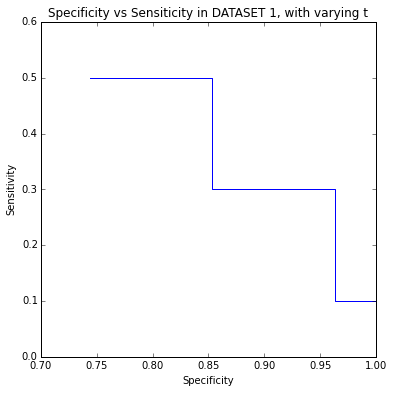

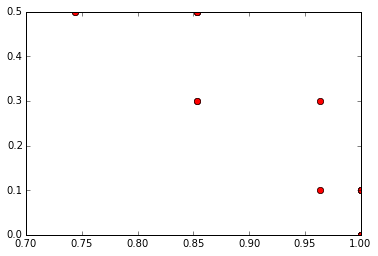

In [22]:
from sklearn.metrics import auc
import matplotlib.pyplot as plt
%matplotlib inline

Sensi1 = sensitivity[:]
Speci1 = specificity[:]
roc_auc1 = auc(Speci1, Sensi1)



plt.figure(figsize=(6,6))
plt.plot(Speci1, Sensi1, label='ROC curve DATASET 1' % roc_auc1)
plt.xlim([0.7, 1.0])
plt.ylim([0.0, 0.6])
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.title('Specificity vs Sensiticity in DATASET 1, with varying t')
plt.show()

plt.plot(Speci1, Sensi1, 'ro')
plt.show()

[0.96, 0.96, 0.96, 0.77, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.26, 0.26, 0.26, 0.26, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.8048780487804879, 0.8048780487804879, 0.8048780487804879, 0.8536585365853658, 0.8536585365853658, 0.8536585365853658, 0.8536585365853658, 0.8536585365853658, 0.8536585365853658, 0.8536585365853658, 0.8536585365853658, 0.8536585365853658, 0.8536585365853658, 0.8536585365853658, 0.8536585365853658, 0.9634146341463414, 0.9634146341463414, 0.9634146341463414, 0.9634146341463414, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


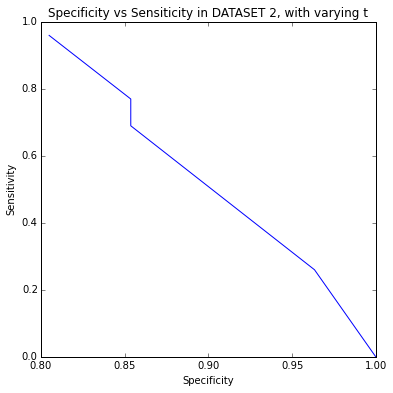

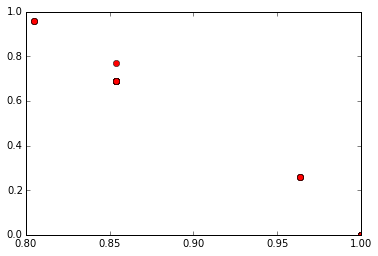

In [24]:
Sensi2 = sensitivity2[:]
Speci2 = specificity2[:]
print(Sensi2)
print(Speci2)
roc_auc2 = auc(Speci2, Sensi2)

plt.figure(figsize=(6,6))
plt.plot(Speci2, Sensi2, label='ROC curve DATASET 2' % roc_auc2)
plt.xlim([0.8, 1.0])
plt.ylim([0.0, 1.00])
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.title('Specificity vs Sensiticity in DATASET 2, with varying t')
plt.show()

plt.plot(Speci2, Sensi2, 'ro')
plt.show()

###PART D
One big problem with the type of training procedure for PWM seen in (b) is that if a nucleotide has never been observed at a given position of the positive sites, then any site that would contain it would be predicted as a negative (its score will be zero). The problem is caused by the fact that a probability distribution cannot be learned accurately from a finite sample. In particular, rare events are often unobserved in a small sample, even though their probability is not zero. One way of partially addressing this problem is to use pseudocounts, which consist of imaginary observations of A, C, G, and T. Specifically, in addition to the actual nucleotides observed in the real data, one would add a certain number x of fake observations:
M(i,j) = ( (# of sites with nucleotide i at position j ) + x ) / (# of sites + 4 x)
Generate and draw the sensitivity-specificity curve for dataset #1 and dataset #2, for x=1. Is it better than that obtained in (c) ?

In [104]:
def createWMfix(positive,x):
    matrix = np.zeros((4,6))
    length = len(positive)
    
    for i in range(length):
        for j in range(len(positive[i])):
            if positive[i][j] =='A':
                matrix[0][j] += 1
            if positive[i][j] =='C':
                matrix[1][j] += 1
            if positive[i][j] =='G':
                matrix[2][j] += 1
            if positive[i][j] =='T':
                matrix[3][j] += 1
    
    for i in range(len(matrix)):
        for j in range(len(matrix[i])):
            matrix[i][j] += x

    length = (length+(4*x))
    
    return matrix/length

def trainingCV2(positive,negative,threshold):
    TruePos = 0
    TrueNeg = 0
    FalsePos = 0
    FalseNeg = 0
    
    pLength = len(positive)
    nLength = len(negative)
    
    p = positive[:]
    n = negative[:]
    
    x = 6
    
    for i in range(pLength):
        p.remove(p[i])
        matrix = createWMfix(p,x)
        
        isPos = isPositive(matrix,positive[i],threshold)
        if isPos:
            TruePos += 1
        else:
            FalsePos += 1
        p = positive[:]
    
    matrix = createWMfix(positive,x)
    for i in range(nLength):
        
        isPos = isPositive(matrix,n[i],threshold)
        if isPos:
            FalseNeg += 1
        else:
            TrueNeg +=1
    
    sensitivity = float(TruePos) / pLength
    specificity = float(TrueNeg) / nLength
    
    return sensitivity,specificity, FalsePos, FalseNeg

def thresholdCV2(positive,negative):
    
    threshold = [float(i)/40 for i in range(1,41)]
    myresult = []
    myresult2 = []
    myresult3 = []
    myresult4 = []
    for i in threshold:
        sensitivity,specificity, FalsePos, FalseNeg = trainingCV2(positive,negative,i)
        myresult.append(sensitivity)
        myresult2.append(specificity)
        myresult3.append(FalsePos)
        myresult4.append(FalseNeg)
    return threshold, myresult, myresult2,myresult3, myresult4

In [105]:
t3,sensitivity3,specificity3,FalsePos3, FalseNeg3 = thresholdCV2(P1,N1)
t4,sensitivity4,specificity4,FalsePos4, FalseNeg4 = thresholdCV2(P2,N2)

In [106]:
for i in range(len(t3)):
    print (t3[i],sensitivity3[i],specificity3[i],FalsePos3[i], FalseNeg3[i])

0.025 1.0 0.0 0 82
0.05 1.0 0.0 0 82
0.075 1.0 0.0 0 82
0.1 1.0 0.0 0 82
0.125 1.0 0.0 0 82
0.15 1.0 0.0 0 82
0.175 1.0 0.0 0 82
0.2 0.5 0.7439024390243902 5 21
0.225 0.5 0.8536585365853658 5 12
0.25 0.3 0.8536585365853658 7 12
0.275 0.1 0.9634146341463414 9 3
0.3 0.1 1.0 9 0
0.325 0.1 1.0 9 0
0.35 0.0 1.0 10 0
0.375 0.0 1.0 10 0
0.4 0.0 1.0 10 0
0.425 0.0 1.0 10 0
0.45 0.0 1.0 10 0
0.475 0.0 1.0 10 0
0.5 0.0 1.0 10 0
0.525 0.0 1.0 10 0
0.55 0.0 1.0 10 0
0.575 0.0 1.0 10 0
0.6 0.0 1.0 10 0
0.625 0.0 1.0 10 0
0.65 0.0 1.0 10 0
0.675 0.0 1.0 10 0
0.7 0.0 1.0 10 0
0.725 0.0 1.0 10 0
0.75 0.0 1.0 10 0
0.775 0.0 1.0 10 0
0.8 0.0 1.0 10 0
0.825 0.0 1.0 10 0
0.85 0.0 1.0 10 0
0.875 0.0 1.0 10 0
0.9 0.0 1.0 10 0
0.925 0.0 1.0 10 0
0.95 0.0 1.0 10 0
0.975 0.0 1.0 10 0
1.0 0.0 1.0 10 0


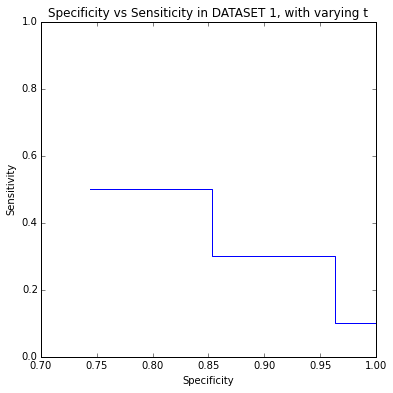

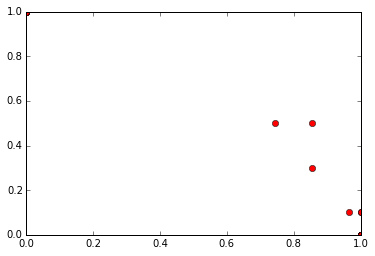

In [107]:
Sensi3 = sensitivity3[:]
Speci3 = specificity3[:]
roc_auc3 = auc(Speci3, Sensi3)



plt.figure(figsize=(6,6))
plt.plot(Speci1, Sensi1, label='ROC curve DATASET 1' % roc_auc3)
plt.xlim([0.7, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.title('Specificity vs Sensiticity in DATASET 1, with varying t')
plt.show()

plt.plot(Speci3, Sensi3, 'ro')
plt.show()

In [108]:
for i in range(len(t4)):
    print (t4[i],sensitivity4[i],specificity4[i],FalsePos4[i], FalseNeg4[i])

0.025 1.0 0.0 0 82
0.05 0.98 0.6829268292682927 2 26
0.075 0.96 0.8048780487804879 4 16
0.1 0.96 0.8048780487804879 4 16
0.125 0.77 0.8048780487804879 23 16
0.15 0.69 0.8536585365853658 31 12
0.175 0.69 0.8536585365853658 31 12
0.2 0.69 0.8536585365853658 31 12
0.225 0.69 0.8536585365853658 31 12
0.25 0.69 0.8536585365853658 31 12
0.275 0.69 0.8536585365853658 31 12
0.3 0.69 0.8536585365853658 31 12
0.325 0.69 0.8536585365853658 31 12
0.35 0.69 0.8536585365853658 31 12
0.375 0.26 0.9634146341463414 74 3
0.4 0.26 0.9634146341463414 74 3
0.425 0.26 0.9634146341463414 74 3
0.45 0.0 0.9634146341463414 100 3
0.475 0.0 1.0 100 0
0.5 0.0 1.0 100 0
0.525 0.0 1.0 100 0
0.55 0.0 1.0 100 0
0.575 0.0 1.0 100 0
0.6 0.0 1.0 100 0
0.625 0.0 1.0 100 0
0.65 0.0 1.0 100 0
0.675 0.0 1.0 100 0
0.7 0.0 1.0 100 0
0.725 0.0 1.0 100 0
0.75 0.0 1.0 100 0
0.775 0.0 1.0 100 0
0.8 0.0 1.0 100 0
0.825 0.0 1.0 100 0
0.85 0.0 1.0 100 0
0.875 0.0 1.0 100 0
0.9 0.0 1.0 100 0
0.925 0.0 1.0 100 0
0.95 0.0 1.0 100 0
0.97

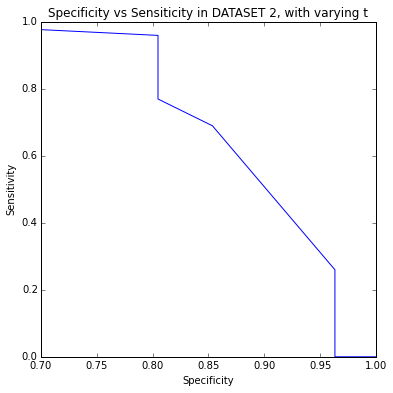

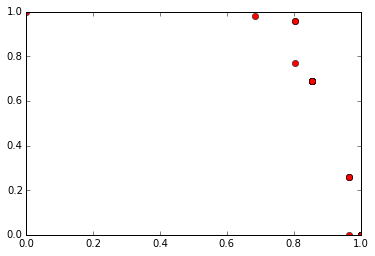

In [109]:
Sensi4 = sensitivity4[:]
Speci4 = specificity4[:]
roc_auc4 = auc(Speci4, Sensi4)

plt.figure(figsize=(6,6))
plt.plot(Speci4, Sensi4, label='ROC curve DATASET 2' % roc_auc4)
plt.xlim([0.7, 1.0])
plt.ylim([0.0, 1.00])
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.title('Specificity vs Sensiticity in DATASET 2, with varying t')
plt.show()

plt.plot(Speci4, Sensi4, 'ro')
plt.show()